#### Notebook config

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

INFO:numexpr.utils._init_num_threads: NumExpr defaulting to 4 threads.


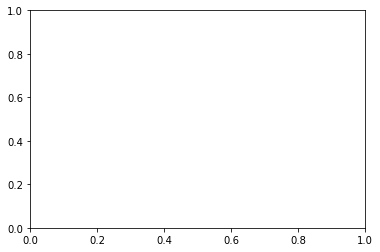

In [3]:
import fwipy 
from fwipy import *
from fwipy.config.logging import *
from fwipy.ioapi.segy import SgyFile
lll(40)

In [4]:
help(fwipy)

Help on package fwipy:

NAME
    fwipy

PACKAGE CONTENTS
    config (package)
    dsp (package)
    fd (package)
    fwi (package)
    generic (package)
    ioapi (package)
    ndat (package)
    numeric (package)
    plot (package)
    project (package)
    seismic (package)
    utils

FILE
    /home/kajetan/software/Kolumbo-FWI/fwipy/__init__.py




#### Example lines

In [94]:
tracf = 4112
ep = 7

# Field data
Filtered as in the PhD thesis.

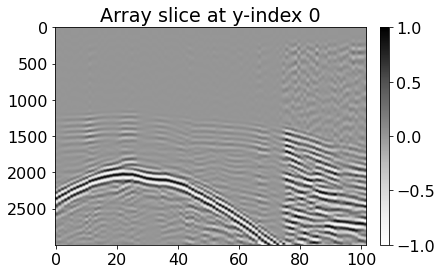

In [38]:
# plot example line 
file_name = 'data_kolumbo_PhD_all_traces_field_filtered.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgyobs = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the starting model.

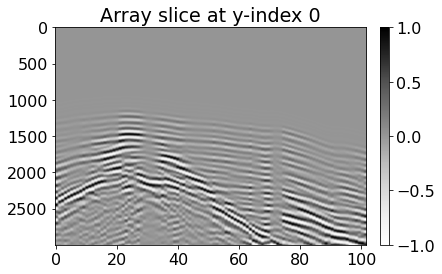

In [68]:
# plot example line 
file_name = 'data_kolumbo_PhD_all_traces_synth_it000.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy000 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the model after 020 iterations.

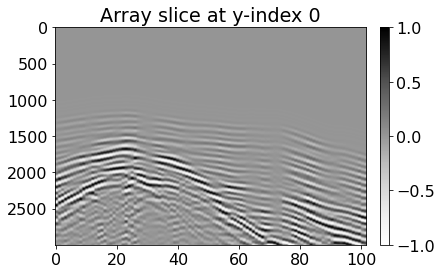

In [64]:
# plot example line 
file_name = 'p14it020syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy020 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the model after 080 iterations.

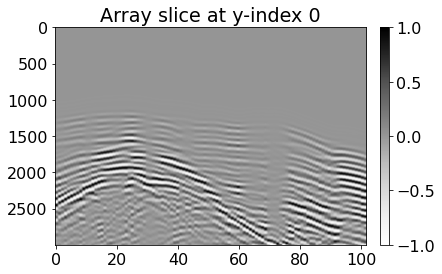

In [65]:
# plot example line 
file_name = 'p14it080syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy080 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the model after 160 iterations.

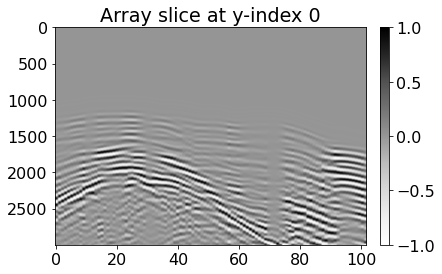

In [66]:
# plot example line 
file_name = 'p14it160syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy160 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# First breaks
From the starting model.

In [31]:
# from fwipy.project.files.datalike.sgy import DataFileSgy, SynDataFileSgy, ObsDataFileSgy

In [25]:
from fullwavepy.ioapi.generic import read_txt
import pandas as pd
fbreaks = read_txt('../data/data_s01-Synthetic_firstbreaks.txt')
fbreaks = [float(i[0]) for i in fbreaks]
dt = .0025
df = pd.read_csv('../data/data_s01-Synthetic_HEAD.csv')
df['fb'] = [int(i) * dt for i in fbreaks]

In [29]:
sgyobs.name

'data_kolumbo_PhD_all_traces_field_filtered.sgy'

# Mute params

In [46]:
 kw_mute = dict(ntaper=100, twin=1)

# Mute field data

In [33]:
%%time
from fullwavepy.seismic.data import DataMuterSUSGY, DataFileSgy
lll(40)
DataMuterSUSGY().mute(sgyobs.fname, tmute=df['fb'], **kw_mute)

CPU times: user 87.2 ms, sys: 59.7 ms, total: 147 ms
Wall time: 6.77 s


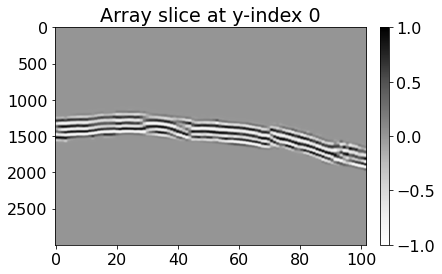

In [39]:
# plot example line 
file_name = 'data_kolumbo_PhD_all_traces_field_filtered_muted.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgyobsmut = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Mute synthetics


In [69]:
%%time 
path = '../data/'
from fullwavepy.seismic.data import DataMuterSUSGY, DataFileSgy
from fwipy.ioapi.su import sushw
tstat = sgyobs.read_header(overwrite=1).tstat.unique()
assert len(tstat) == 1
# tstat[0]
for sgyref in [sgy000, sgy020, sgy080, sgy160]:
    syn = Dat(dt=.0025, file=DataFileSgy(sgyref.name, path))
    sushw(syn.file.fname, 'tstat', tstat)
    DataMuterSUSGY().mute(sgyref.fname, tmute=df['fb'], **kw_mute)

CPU times: user 1.26 s, sys: 220 ms, total: 1.48 s
Wall time: 20.2 s


# Init all muted data

In [92]:
data_path = '../data/'
sgyobsm = SgyFile('data_kolumbo_PhD_all_traces_field_filtered_muted.sgy', data_path)
sgy000m = SgyFile('data_kolumbo_PhD_all_traces_synth_it000_muted.sgy', data_path)
sgy020m = SgyFile('p14it020syn-Synthetic_muted.sgy', data_path)
sgy080m = SgyFile('p14it080syn-Synthetic_muted.sgy', data_path)
sgy160m = SgyFile('p14it160syn-Synthetic_muted.sgy', data_path)

# Wiggly plots
With acquisition geometry

In [49]:
# read ids 
file_name = 'method_s01-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy1 = sgy
OBS_ids = sorted(sgy.read_header().tracf.unique())
print(OBS_ids)
shot_line_ids = sorted(sgy.head.ep.unique())
print(shot_line_ids)

[4104, 4105, 4109, 4110, 4112, 4123, 4124, 4125, 4137, 4138, 4139, 4157, 4158, 4176, 4177, 4178]
[5, 6, 7, 8, 9, 10, 22, 23, 26, 27, 30, 31, 37, 38]


In [84]:
def get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000):
    x1 = min(min(srcs_x), min(recs_x)) #- pad
    y1 = min(min(srcs_y), min(recs_y)) - pad
    x2 = max(max(srcs_x), max(recs_x)) #+ pad
    y2 = max(max(srcs_y), max(recs_y)) + pad
    return x1, x2, y1, y2
def get_sr_coords(h, tracf, ep):
    df = h.loc[h.ep==ep]
    srcs_x = df.sx
    srcs_y = df.sy
    df = h.loc[h.tracf==tracf]
    recs_x = df.gx.unique()
    recs_y = df.gy.unique()
    return srcs_x, srcs_y, recs_x, recs_y
def calc_offset3d(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    df['offset3d'] = np.sqrt((df['sx'] - df['gx'])**2 +
                             (df['sy'] - df['gy'])**2 +
                             (df['selev'] + df['gelev'])**2)
    return df['offset3d']
def read_data_and_header(sgy1, sgy2, tracf, ep):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    # Read and normalise seismic data
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    # Read metadata from SEGY header
    h = sgy1.read_header(overwrite=0)
    h = h.loc[(h.tracf==tracf) & (h.ep==ep)]
    calc_offset3d(h)
    return a1, a2, h
def compare_wiggles_acq(sgy1, sgy2, tracf, ep, dt=0.0025, A1=10, A2=10, k_lvz=55,
                        vel_red = 5000, # reduction velocity (m/s), #geom_factor=8000,
                        tmin=None, tmax=None,figsize=(10,5),
                        lw = 1, l1='field', l2=None, c_line1 = 'r', c_line2='k'):
    a1, a2, h = read_data_and_header(sgy1, sgy2, tracf, ep)
    ntr, ns = a1.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(211)
    zero_vel = 1e-3
    for i, (x, offset3d) in enumerate(zip(h.sx, h.offset3d)):
        if abs(vel_red) > zero_vel:
            t = np.arange(0, ns) * dt - offset3d / vel_red
        else:
            t = np.arange(0, ns) * dt
        ax.plot(x + a1[i] * A1, t, color=c_line1, lw=lw, label=l1)
        ax.plot(x + a2[i] * A2, t, color=c_line2, lw=lw, label=l2)
    ax.set_xlim(min(h.sx), max(h.sx))
    ax.invert_yaxis()    
    plt.xlabel('X (m)')
    if abs(vel_red) > zero_vel:
        plt.ylabel('Reduced time (s) for vel_r= %s m/s' % vel_red)
    else:
        plt.ylabel('Time (s)')
    ax2 = ax.twiny()
    x1, x2 = ax.get_xbound()
    ax2.set_xbound(x1,x2)
    every = 20
    xticks = h.sx.values[::every]
    xlabels = [int(i) for i in h.offset3d[::every]]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)
    ax2.set_xlabel("Offset 3D (m)")
    plt.ylim(tmax,tmin)
    
    axin = fig.add_subplot(212)
    vp.plot(z=k_lvz, cmap='twilight', vmin=3700, vmax=5000, title=None, cbar=0)
    shotsize, shotcolor = 2, 'r'
    srcs_x, srcs_y, recs_x, recs_y = get_sr_coords(h, tracf, ep)
    x1, x2, y1, y2 = get_bounds(srcs_x, srcs_y, recs_x, recs_y, pad=1000)    
    axin.plot(srcs_x, srcs_y, linestyle='', marker='.', label='shot',
             markersize=1, markerfacecolor=shotcolor, markeredgecolor=shotcolor)
    axin.plot(recs_x, recs_y, marker='o', linestyle='', markersize=shotsize*3, 
                   markeredgecolor='k', markeredgewidth=1, markerfacecolor='b')    
    shift = 100
    for x, y in zip(recs_x, recs_y):
        xytext = (x+shift, y+shift)
        axin.annotate(text=str(tracf), xy=(x,y), xytext=xytext, clip_on=True, fontsize=8,
                    #bbox={'facecolor': 'k', 'edgecolor': 'w', 'alpha': .5, }
                     )    
    axin.set_xlim(x1,x2)
    axin.set_ylim(y1, y2)
    #axin.set_xticks([])
    axin.set_yticks([])
    bt.plot(mode='contour', aspect='equal')    

In [54]:
from arrau.a2d import Arr2d
xp = PROTEUS()
xp.read_all()
b01 = Box3d(+8.0e3, +2.5e4 , -3.0e3, +1.5e4, 0, +4.0e3)
bt = Arr2d(xp.bt.extract(extent=b01.xy).arr, extent=np.array(b01.xy))
vp = Arr3d(source='../data/p14-CP00160-Vp.mmp', shape=(341,361,81), extent=b01.extent)

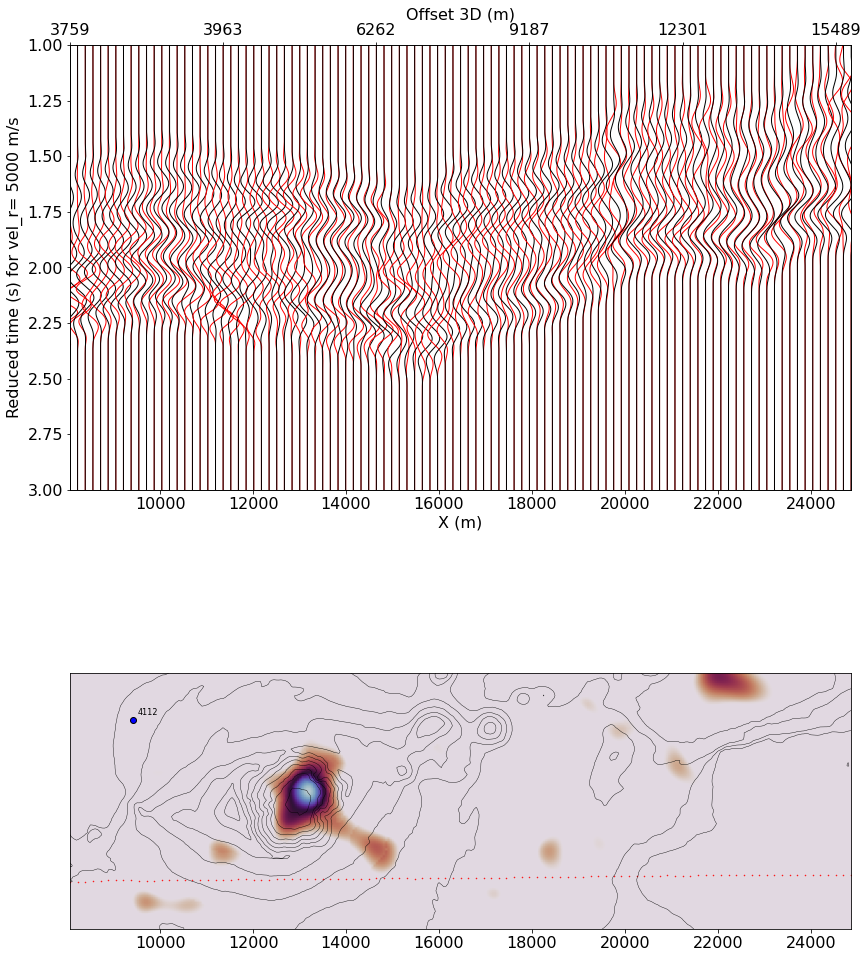

In [99]:
compare_wiggles_acq(sgyobsm, sgy000m, tracf=tracf, ep=ep, vel_red=5000, tmin=1, tmax=3,
                    figsize=(14,18), k_lvz=55,A1=30, A2=30)

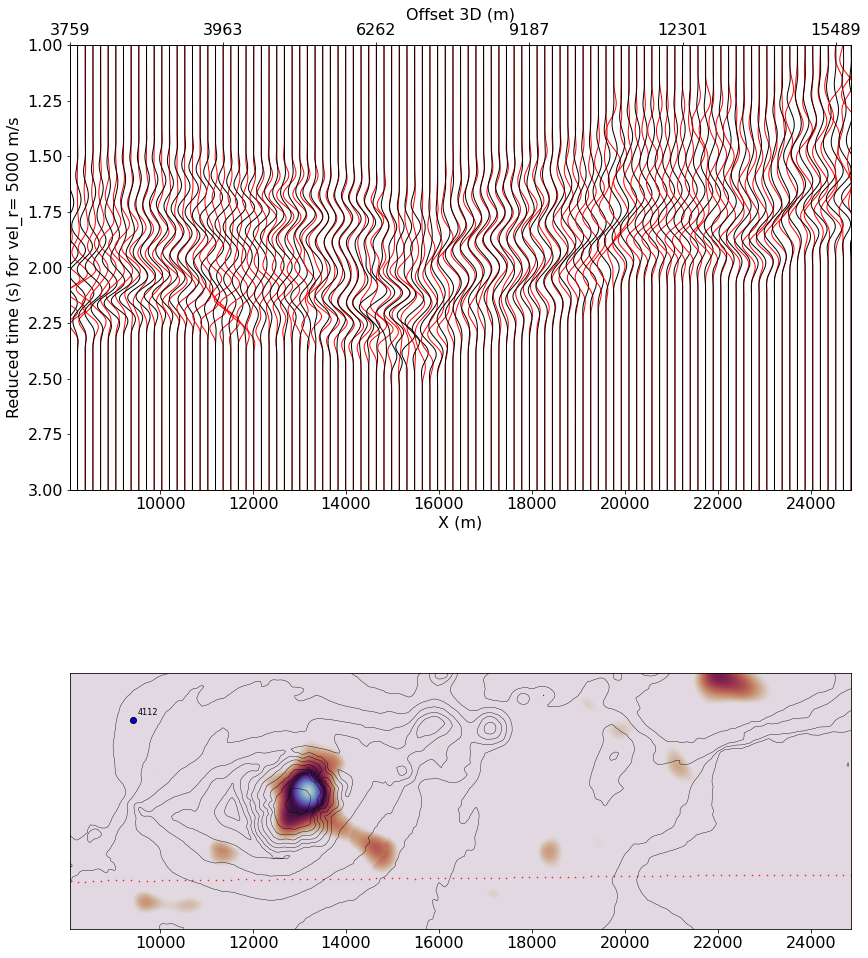

In [101]:
compare_wiggles_acq(sgyobsm, sgy160m, tracf=tracf, ep=ep, vel_red=5000, tmin=1, tmax=3,
                    figsize=(14,18), k_lvz=55,A1=30, A2=30)

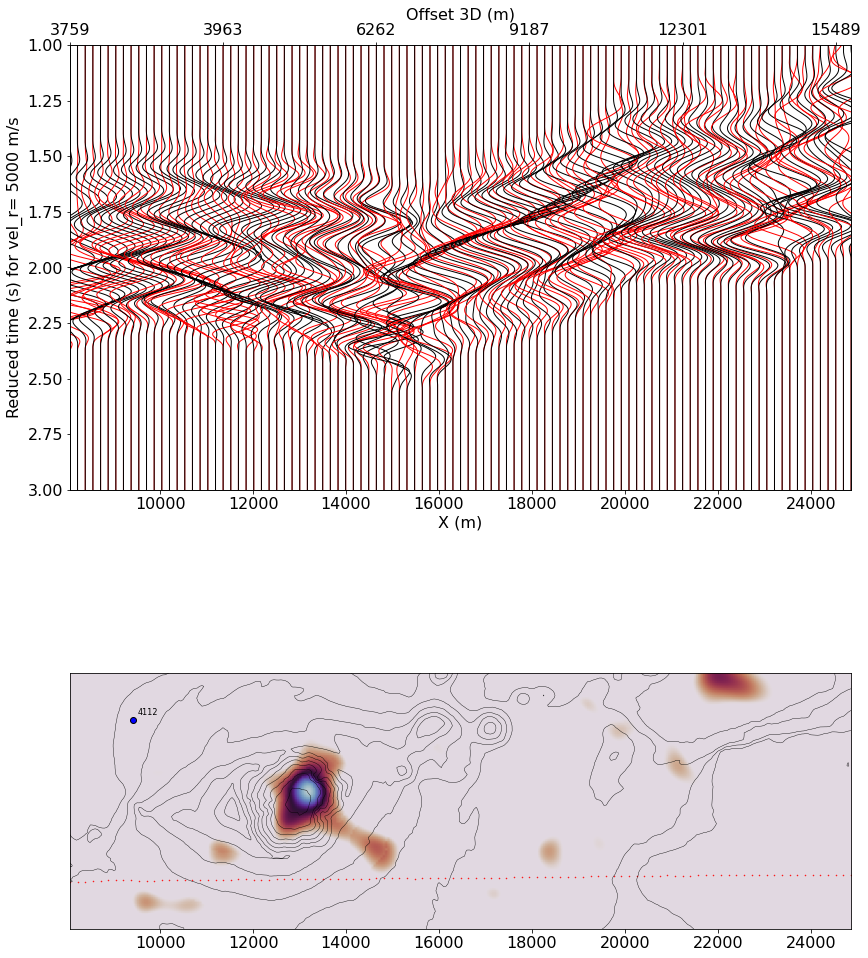

In [96]:
compare_wiggles_acq(sgyobsm, sgy020m, tracf=tracf, ep=ep, vel_red=5000, tmin=1, tmax=3,
                    figsize=(14,18), k_lvz=55,A1=100, A2=100)

In [102]:
obs_above = [4104, 4105, 4109, 4110, 4112]
obs_below_close = [4123, 4124, 4125, 4137, 4138, 4139]
obs_below_far = [4157, 4158, 4176, 4177, 4178]

ep_above = [5, 6, 30, 31, 37, 38]
ep_below_close = [7, 8, 27]
ep_below_far = [9, 10, 22, 23, 26]

In [ ]:
%%time 
def plot(sgyobs, sgyref, *args, **kwargs):
    return compare_wiggles_acq(sgyobs, sgyref, *args, **kwargs)
kwargs = dict(vel_red=5000, tmin=1, tmax=3,
                    figsize=(14,18), k_lvz=55,A1=100, A2=100)
sgysyn = {0: sgy000m, 20: sgy020m, 80: sgy080m, 160: sgy160m}
for sid in OBS_ids: #obs_below_close: #obs_above:
    for lid in shot_line_ids: #ep_above: #ep_below_close:
        for it in [0, 160]:
            try:
                plot(sgyobsm, sgysyn[it], tracf=sid, ep=lid, **kwargs)
                plt.savefig('figures/wiggles_muted_acq/p14_BB_wigg_m_acq_OBS%s_line%s_it%s.png' % (sid, str(lid).rjust(3, '0'), str(it).rjust(3, '0')))
                plt.close()
            except AssertionError:
                print('WARNING no data for OBS %s, line %s' % (sid, lid))
#         break
#     break

# ...